# Demanda de transporte

## `Auxiliar: Redes neuronales artificiales`

**Junio 2024**<br>
**Gabriel Nova** <br>
**G.N.Nova@tudelft.nl** <br>

### `Instrucciones`

**Las sesiones de laboratorio son:**<br>
* Entornos de aprendizaje donde trabajas con Jupyter y puedes resolver dudas.<br>
* No son calificadas y no tienen que ser entregadas.

### `Configuración del entorno de trabajo`

**Opción 1: Entorno local**<br>
Descomenta la siguiente celda si estás ejecutando este cuaderno en tu entorno local, para instalar todas las dependencias en tu versión de Python.


In [67]:
#!pip install -r requirements.txt

**Opción 2: Google Colab**<br>
Descomenta la siguiente celda si estás ejecutando este cuaderno en Google Colab.

In [68]:
#!git clone https://github.com/TransportDemand/CI5144
#!pip install -r CI5144/requirements_colab.txt
#!mv "/content/CI5144/Auxiliares/data" /content/data

# `Aplicación: Modelo de elección de modos de transporte`

En este auxiliar, se busca analizar el comportamiento de elección de modos de transporte. Comprender las preferencias de las personas sobre los atributos de transporte es crucial para los planificadores urbanos cuando desarrollan políticas para mejorar la movilidad urbana sostenible. Durante esta sesión de laboratorio, aplicarás modelos de elección discreta para descubrir las preferencias de las personas sobre atributos como el tiempo de viaje, el costo del viaje, el tiempo de acceso y el nivel de servicio. Además, explorarás si las preferencias interactúan con covariables como género, propósito de viaje y e ingresos. Mientras lo haces, probarás varias especificaciones de utilidad e interpretarás los resultados del modelado de los modelos de elección discreta.

Para este estudio, utilizamos datos de un experimento de Elección Declarada (SC) proporcionado por [Apollo](https://www.apollochoicemodelling.com/examples.html)

**`Objetivos de aprendizaje del auxiliar`**

Después de completar los siguientes ejercicios, podrás: <br>
* Preparar datos de (elección) para entrenar Redes Neuronales Artificiales
* Entrenar Perceptrón Multicapa (MLP) - un tipo particular de red neuronal - para una tarea de clasificación<br>
* Ajustar los hiperparámetros y arquitecturas de la red para mejorar el rendimiento del modelo<br>
* Evaluar el rendimiento de modelos cpnvencionales, basados en varias medidas de rendimiento, incluyendo matrices de confusión, precisión, recuperación, F1 y coeficiente de Matthews<br>



**`Este laboratorio consta de 6 partes`**
1. Preparación de datos (elección) para entrenar Redes Neuronales Artificiales
2. Entrenamiento de una red neuronal Perceptrón Multicapa (MLP)
3. Uso de detención temprana para evitar el sobreajuste
4. Uso de validación cruzada k-fold para evaluar el rendimiento de generalización
5. Ajuste de hiperparámetros
6. Evaluación del rendimiento de los modelos entrenados

y comprende **`7`** ejercicios.


#### `Importar packages`

Para empezar, importaremos todas las librerías de Python que utilizaremos en el auxiliar

In [1]:
# Importar paquetes y módulos Python necesarios
import os
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

# Importar funciones y clases seleccionadas de paquetes Python
from os import getcwd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, log_loss, matthews_corrcoef, make_scorer, classification_report

# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Variable, log

# Setting
pd.set_option('display.max_columns', None)

#### `0. Preparación de datos (de elección) para entrenar Redes Neuronales Artificiales`
Para preparar el conjunto de datos, realizaremos lo siguiente:<br>
    1.1 **Cargar** el conjunto de datos<br>
    1.2 **Inspeccionar** y **Limpiar** el conjunto de datos<br>
    1.3 **Descubrir y visualizar** los datos <br>

`i. Configurar el espacio de trabajo y cargar la base de datos`

In [2]:
# Obtener el ruta a la base de datos
data_path =  Path(f'data/apollo_modeChoiceData.csv')
print(data_path)

data\apollo_modeChoiceData.csv


In [71]:
# Cargar datos de elección de modo en un pandas DataFrame
df = pd.read_csv(data_path,sep = ',')
df = df[df['SP']==1]
df.shape

(7000, 26)

**Inspeccionar y limpiar los datos**<br>
Antes de empezar a analizar tus datos, asegúrate de que entiendes qué atributos y características tienen hay en la base de datos.

In [72]:
df.head()

,ID,RP,SP,RP_journey,SP_task,av_car,av_bus,av_air,av_rail,time_car,cost_car,time_bus,cost_bus,access_bus,time_air,cost_air,access_air,service_air,time_rail,cost_rail,access_rail,service_rail,female,business,income,choice
2,1,0,1,NaN,1.00,0,0,1,1,0,0,0,0,0,50,50,55,3,170,35,5,2,0,0,46705,4
3,1,0,1,NaN,2.00,0,0,1,1,0,0,0,0,0,90,65,45,1,120,75,5,3,0,0,46705,4
4,1,0,1,NaN,3.00,0,0,1,1,0,0,0,0,0,70,110,40,1,155,75,25,2,0,0,46705,4
5,1,0,1,NaN,4.00,0,0,1,1,0,0,0,0,0,90,80,40,1,170,35,25,2,0,0,46705,4
6,1,0,1,NaN,5.00,0,0,1,1,0,0,0,0,0,90,80,35,2,130,75,25,2,0,0,46705,3


**Descripción de variables**<br>

Por lo tanto, se recomienda revisar la descripción de la base de datos.

| Variable       | Descripción                                           | Valores                                                |
|----------------|-------------------------------------------------------|-------------------------------------------------------|
| ID             | Identificador único del individuo                    | 1 a 500                                               |
| RP             | Identificador de datos de RP                         | 1 para RP, 0 para SP                                   |
| SP             | Identificador de datos de SP                         | 1 para SP, 0 para RP                                   |
| RP_journey     | Índice para observaciones de RP                      | 1 a 2, NA para SP                                      |
| SP_task        | Índice para observaciones de SP                      | 1 a 14, NA para RP                                     |
| av_car         | Disponibilidad para la alternativa 1 (coche)         | 1 para disponible, 0 para no disponible               |
| av_bus         | Disponibilidad para la alternativa 2 (autobús)      | 1 para disponible, 0 para no disponible               |
| av_air         | Disponibilidad para la alternativa 3 (avión)        | 1 para disponible, 0 para no disponible               |
| av_rail        | Disponibilidad para la alternativa 4 (tren)         | 1 para disponible, 0 para no disponible               |
| time_car       | Tiempo de viaje (minutos) para la alternativa 1 (coche) | Mín: 250, media: 311.79, máx: 390 (0 si no está disponible) |
| cost_car       | Costo de viaje (£) para la alternativa 1 (coche)    | Mín: 30, media: 39.99, máx: 50 (0 si no está disponible) |
| time_bus       | Tiempo de viaje (minutos) para la alternativa 2 (autobús) | Mín: 300, media: 370.29, máx: 420 (0 si no está disponible) |
| cost_bus       | Costo de viaje (£) para la alternativa 2 (autobús)  | Mín: 15, media: 25.02, máx: 35 (0 si no está disponible) |
| access_bus     | Tiempo de acceso (minutos) para la alternativa 2 (autobús) | Mín: 5, media: 15.02, máx: 25 (0 si no está disponible) |
| time_air       | Tiempo de viaje (minutos) para la alternativa 3 (avión) | Mín: 50, media: 70.07, máx: 90 (0 si no está disponible) |
| cost_air       | Costo de viaje (£) para la alternativa 3 (avión)    | Mín: 50, media: 79.94, máx: 110 (0 si no está disponible) |
| access_air     | Tiempo de acceso (minutos) para la alternativa 3 (avión) | Mín: 35, media: 45.02, máx: 55 (0 si no está disponible) |
| service_air    | Calidad del servicio para la alternativa 3 (avión)   | 1 para básico, 2 para wifi, 3 para comida (0 si no se usa, datos de RP) |
| time_rail      | Tiempo de viaje (minutos) para la alternativa 4 (tren) | Mín: 120, media: 142.93, máx: 170 (0 si no está disponible) |
| cost_rail      | Costo de viaje (£) para la alternativa 4 (tren)     | Mín: 35, media: 55.03, máx: 75 (0 si no está disponible) |
| access_rail    | Tiempo de acceso (minutos) para la alternativa 4 (tren) | Mín: 5, media: 14.96, máx: 25 (0 si no está disponible) |
| service_rail   | Calidad del servicio para la alternativa 4 (tren)    | 1 para básico, 2 para wifi, 3 para comida (0 si no se usa, datos de RP) |
| female         | Variable ficticia para individuos femeninos          | 1 para femenino, 0 para otro                           |
| business       | Variable ficticia para viajes de negocios            | 1 para viajes de negocios, 0 para otro                 |
| income         | Variable de ingresos (£ por año)                     | Mín: 15,490, media: 44,748.27, máx: 74,891             |
| choice         | Variable de elección                                 | 1 para coche, 2 para autobús, 3 para avión, 4 para tren |



**`Estadísticas descriptivas`**<br>

Podemos usar `describe()` para ver estadísticas descriptivas, como recuento, media, desviación estándar, mínimo, percentiles y máximo sobre los **niveles de atributos** de las alternativas.

In [73]:
# Limpieza de datos

# Lista de id relevantes
id         = ['ID', 'SP_task' ] 

# Atributos de modos de transporte
attributes =   ['time_car',  'cost_car', 
                'time_bus',  'cost_bus',  'access_bus',
                'time_air',  'cost_air',  'access_air',  'service_air', 
                'time_rail', 'cost_rail', 'access_rail', 'service_rail']

# Características: Variable socio-demograficas
sociovars = ['female', 'business','income']

# Disponibilidad de modos de transporte
av = ['av_car', 'av_bus', 'av_rail', 'av_air']

# Creacion de dataframe con las variables de interés
dff = df[id + attributes + sociovars + av +['choice'] ].copy()

print(dff.shape)
dff

(7000, 23)


,ID,SP_task,time_car,cost_car,time_bus,cost_bus,access_bus,time_air,cost_air,access_air,service_air,time_rail,cost_rail,access_rail,service_rail,female,business,income,av_car,av_bus,av_rail,av_air,choice
2,1,1.00,0,0,0,0,0,50,50,55,3,170,35,5,2,0,0,46705,0,0,1,1,4
3,1,2.00,0,0,0,0,0,90,65,45,1,120,75,5,3,0,0,46705,0,0,1,1,4
4,1,3.00,0,0,0,0,0,70,110,40,1,155,75,25,2,0,0,46705,0,0,1,1,4
5,1,4.00,0,0,0,0,0,90,80,40,1,170,35,25,2,0,0,46705,0,0,1,1,4
6,1,5.00,0,0,0,0,0,90,80,35,2,130,75,25,2,0,0,46705,0,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,500,10.00,300,45,300,30,10,0,0,0,0,170,35,5,3,0,1,19910,1,1,1,0,4
7996,500,11.00,275,50,360,15,20,0,0,0,0,130,65,15,3,0,1,19910,1,1,1,0,4
7997,500,12.00,345,30,360,25,25,0,0,0,0,140,75,5,2,0,1,19910,1,1,1,0,1
7998,500,13.00,250,50,420,20,20,0,0,0,0,130,65,10,2,0,1,19910,1,1,1,0,4


**Descubriendo y visualizando los datos**<br>
Antes de comenzar a analizar sus datos con modelos, es recomendable comenzar con algunos **análisis descriptivos**.<br>
Por lo tanto, se recomienda primero observar la distribución y correlaciones de las características clave en los datos.

#### ``Ejercicio 1: ¿La base de datos está (des)balanceada?``
`A` Crea un histograma que muestre con qué frecuencia se eligen Auto, Bus, Avión y Tren. No olvides agregar etiquetas a las columnas<br>
`B` Interpreta el histograma. ¿La base de datos está (des)balanceada?<br>

$\color{green}{\text{Añada aquí sus respuestas}}$

C:\Users\gnova\AppData\Local\Temp\ipykernel_36540\1791783378.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(ylabels)


[Text(0, 0, 'Car'), Text(1, 0, 'Bus'), Text(2, 0, 'Air'), Text(3, 0, 'Rail')]

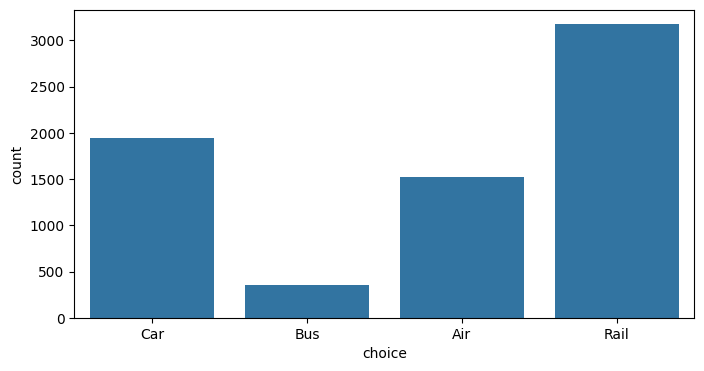

In [74]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes = sns.countplot(x = "choice", data = dff)
ylabels = ['Car', 'Bus', 'Air','Rail']
axes.set_xticklabels(ylabels)

In [75]:
# RESPUESTAS
# A) Creamos un histograma utilizando sns, donde contamos la variable objetivo "choice"
# B) Observamos que la variable objetivo no está bien balanceada. El avión es elegido más a menudo que los otros modos. Como Afecta esto a la calidad del modelo?

#### ``Ejercicio 2: Explorar correlaciones entre características``
`A` Crea un mapa de calor para identificar qué características se correlacionan particularmente con la variable **Choice**<br>
`B` Identifica las características que se correlacionan fuertemente (corr >0.9) (si las hay). ¿Tienen sentido?<br>

$\color{green}{\text{Añada aquí sus respuestas}}$

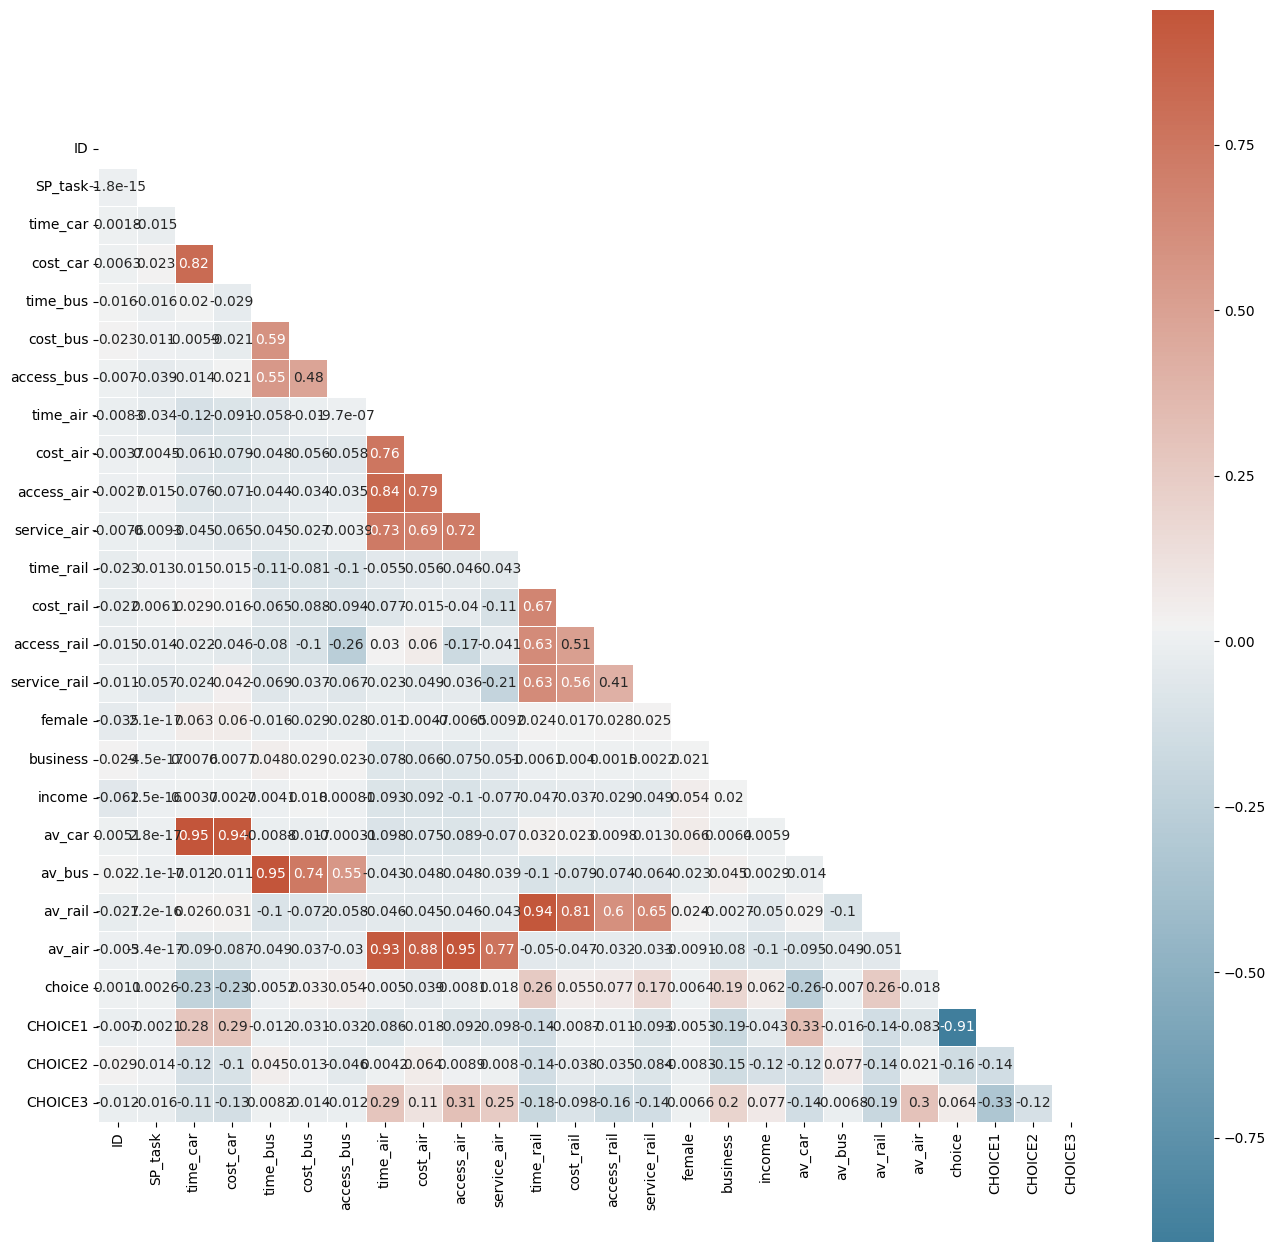

In [76]:
# Mapa de calor de correlaciones
# Crear gráfico
f, axes = plt.subplots(figsize=(16,16))
fig.set_tight_layout(True)

# Como la elección es categórica, las codificamos como dummies (a.k.a dummy encoding // one-hot encoding)
dff2 = dff.copy()
dff2['CHOICE1'] = dff2['choice'] == 1
dff2['CHOICE2'] = dff2['choice'] == 2
dff2['CHOICE3'] = dff2['choice'] == 3

# Calculo de la matriz de correlation
corr = dff2.corr()

# Crear una matriz triangular superior para ocultar la parte triangular superior del heatmap
corr_mask = np.triu(np.ones_like(corr, dtype=bool))

# Genera un mapa de colores personalizado divergente (porque se ve mejor)
corr_cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Graficar el  heatmap
sns.heatmap(corr, mask = corr_mask, cmap=corr_cmap, annot=True,square = True, linewidths=.5, ax = axes)
plt.show()

In [77]:
# RESPUESTAS
# A) Debido a que CHOICE es una variable categórica, primero debemos crear 3 nuevas variables codificadas en caliente para CHOICE ==1, CHOICE == 2 y CHOICE == 3.
# Después de eso, calculamos las correlaciones y visualizamos la correlación en un mapa de calor.

# B) En general, observamos que el costo y el tiempo de viaje se correlacionan fuertemente, dentro y entre los modos. Esto tiene perfecto sentido.
# Service_rail correlaciona positivamente con time_rail y cost_rail. Esto también es lógico, ya que un mejor servicio debería ser más caro y tomar más tiempo.

#### `1. Estimar modelo de elección discreta de referencia`<br>
Como referencia, utilizamos el modelo de maximización de la utilidad aleatoria lneal en los parámetros. Estimamos este modelo usando `biogeme`.

In [78]:
# Convertir la base de datos dff en una base de datos biogeme
biodata = db.Database('Apollo_mode_choice_data', dff)

In [79]:
# Crear variables Biogeme

# Attributes of alternative 1
time_car     = Variable('time_car')
cost_car     = Variable('cost_car')

# Attributes of alternative 2    
time_bus     = Variable('time_bus')
cost_bus     = Variable('cost_bus')
access_bus   = Variable('access_bus')
    
# Attributes of alternative 3
time_air     = Variable('time_air')
cost_air     = Variable('cost_air')
access_air   = Variable('access_air')
service_air  = Variable('service_air')

# Attributes of alternative 4
time_rail     = Variable('time_rail')
cost_rail     = Variable('cost_rail')
access_rail   = Variable('access_rail')
service_rail  = Variable('service_rail')

# Availability variables
av_car       = Variable('av_car')
av_bus       = Variable('av_bus')
av_rail      = Variable('av_rail')
av_air       = Variable('av_air')

# choice
choice      = Variable('choice')

In [80]:
# Dar nombre al modelo    
model_name = 'Linear-additive RUM-MNL'

# Define los parámetros del modelo, usando la función «Beta()», en la cual debes definir:
B_time        = Beta('B_time',      0, None, None, 0)
B_cost        = Beta('B_cost',      0, None, None, 0)
B_access      = Beta('B_access',    0, None, None, 0)
B_service     = Beta('B_service',   0, None, None, 0)
ASC_car       = Beta('ASC_car',     0, None, None, 1)
ASC_bus       = Beta('ASC_bus',     0, None, None, 0)
ASC_air       = Beta('ASC_air',     0, None, None, 0)
ASC_rail      = Beta('ASC_rail',    0, None, None, 0)

# Definir la forma funcional de las utilidades
V1 = ASC_car +  B_time * time_car   + B_cost * cost_car
V2 = ASC_bus +  B_time * time_bus   + B_cost * cost_bus  + B_access * access_bus
V3 = ASC_air +  B_time * time_air   + B_cost * cost_air  + B_access * access_air  + B_service * service_air
V4 = ASC_rail + B_time * time_rail + B_cost * cost_rail + B_access * access_rail + B_service * service_rail

# Construir un diccionario con las utilidades de cada alternativa
V = {1: V1, 2: V2, 3: V3, 4: V4}    

# Construir un diccionario con las disponibilidad de cada alternativa
AV = {1: av_car, 2: av_bus, 3: av_air, 4: av_rail} 

# Definicion del modelo. Es decir, es la contribución de cada observación a la función log likelihood.
prob = models.logit(V, AV, choice)

# Crear el objeto Biogeme
biogeme = bio.BIOGEME(biodata, log(prob))

# Configurar reporte
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name

# Calcular el valor de la funcion loglikelihood con parametros nulos para el reporte
biogeme.calculateNullLoglikelihood(AV)

# Estimar paramtetros
results_rum_mnl = biogeme.estimate()
print(results_rum_mnl.short_summary())

# Presentar los resultados en una tabla
beta_hat = results_rum_mnl.getEstimatedParameters()
print(beta_hat)

Results for model Linear-additive RUM-MNL
Nbr of parameters:		7
Sample size:			7000
Excluded data:			0
Null log likelihood:		-8196.021
Final log likelihood:		-5761.741
Likelihood ratio test (null):		4868.56
Rho square (null):			0.297
Rho bar square (null):			0.296
Akaike Information Criterion:	11537.48
Bayesian Information Criterion:	11585.46

           Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_air    -0.31          0.18        -1.69          0.09
ASC_bus    -2.05          0.08       -26.83          0.00
ASC_rail   -0.61          0.11        -5.37          0.00
B_access   -0.02          0.00        -7.63          0.00
B_cost     -0.06          0.00       -37.84          0.00
B_service   0.18          0.02         7.76          0.00
B_time     -0.01          0.00       -19.34          0.00


In [81]:
type(V)

dict

#### `2. Entrenamiento de una red neuronal de perceptrón multicapa (MLP)`
Para entrenar Redes Neuronales Artificiales, seguimos los siguientes pasos:<br>
    2.1 **Esclar** las características<br>
    2.2 **Separar** los datos en un conjunto de datos de entrenamiento y evaluación<br>
    2.3 **Crear el objeto MLP**<br>
    2.4 **Entrenar el MLP** en los datos de entrenamiento<br>
    2.5 **Evaluar** el rendimiento

`i. Escalar las características`<br>

Para entrenar eficientemente ANNs, se recomienda encarecidamente **escalar** (también conocido como normalizar) las características. 

Hay varias formas de escalar sus datos. Un escalador comúnmente utilizado de `sk-learn` se llama 'StandardScaler'. Este escalador normaliza la varianza y desplaza la ubicación de la distribución a cero, consulte https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [82]:
# Crea la lista de características que necesitan ser escaladas.
# Importante, esto excluye las disponibilidades y la elección
features2scale = attributes + sociovars 

# Iniciar objeto escalador y ajustar a los datos
scaler = StandardScaler()  
dff_scaled_f = scaler.fit_transform(dff.loc[:,features2scale]) 
dff_scaled_f = pd.DataFrame(dff_scaled_f, columns = features2scale) 
dff_scaled_f.reset_index(drop=True, inplace=True)  # Reset indices

# Crear un nuevo dataframe X_scaled que contenga las características escaladas Y las (no escaladas)
dff_scaled = dff.copy()
dff_scaled.reset_index(drop=True, inplace=True)
dff_scaled[features2scale] = dff_scaled_f

`ii. Separar los datos en un conjunto de entrenamiento y un conjunto de evaluación`<br>

Entrenar modelos de ML siempre implica un conjunto de datos de **entrenamiento** y un conjunto de datos de **evaluación**. 

El conjunto de entrenamiento se utiliza para actualizar los pesos(coeficientes) del modelo. El conjunto de evaluación se utiliza para evaluar el **generalización de rendimiento** del modelo.

In [83]:
# Crear la lista de características que queremos utilizar en el modelo

features = attributes + sociovars + av

# Crear la variable objetivo
Y = dff_scaled['choice']

# Divide los datos usando la función `train_test_split` de sk-learn.
# Tenga en cuenta que utilizamos el 60% para el entrenamiento y el 40% para la evaluación
# Tenga en cuenta que fijamos el random_state, con el fin de replicar los resultados más tarde (no cambiar) 
X_train, X_test, Y_train, Y_test = train_test_split(dff_scaled[features], Y, random_state = 12345, test_size = 0.4)

# Almacenar los índices de los conjuntos de pruebas para su uso posterior
test_indices = X_test.index.values

`iii. Creación del objeto MLP`<br>

Un Perceptrón Multicapa (MLP) es una red neuronal que sus nodos estan completamente conectados. Creamos el MLP usando la función MLPClassifier de `sk-learn`.

In [84]:
# Creamos el objeto MLP 'base'
# Declaramos el número de capas y nodos por capa
# layers = (a,b) significa dos capas con a nodos en la 1ra capa oculta y b nodos en la 2da capa oculta
layers = (90,)

# Definimos la arquitectura del MLP, el optimizador y los hiperparámetros:
# Usamos el optimizador Adam
# Usamos una tasa de aprendizaje de 0.001
# Usamos regularización L2 de 0
# Usamos un batch_size de 250 observaciones
# Usamos la función de activación relu
# Establecemos el número máximo de épocas en 2000
mlp = MLPClassifier(hidden_layer_sizes=layers, solver='adam', learning_rate_init=0.001, alpha=0, batch_size=250, activation='relu', max_iter=2000)

`iv. Entrenando el MLP`<br>
Para entrenar el MLP, usamos la función '.fit'.

In [85]:
# Entrenar el MLP usando los datos de entrenamiento
mlp.fit(X_train, Y_train)

MLPClassifier(alpha=0, batch_size=250, hidden_layer_sizes=(90,), max_iter=2000)

Text(0.5, 1.0, 'Pérdida de entropía cruzada considerando los datos de entrenamiento. \nMejor CE = 0.506')

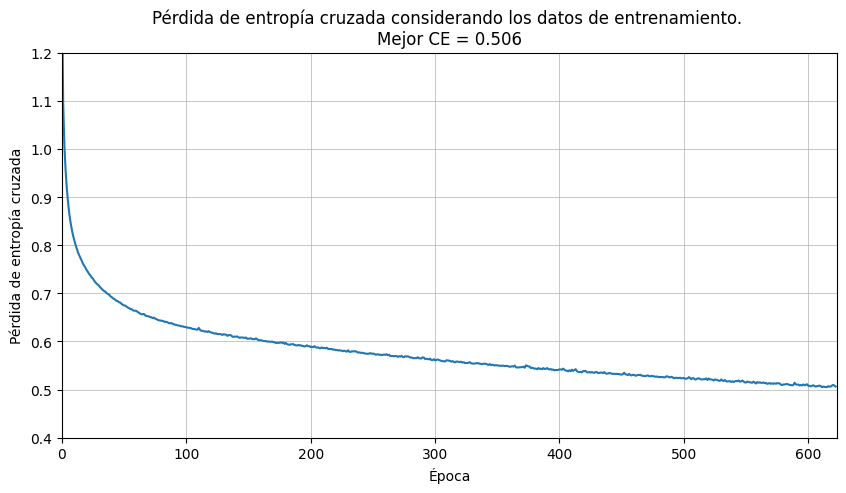

In [86]:
# Es buena práctica observar la curva de aprendizaje para ver cuánto ha mejorado el modelo desde el punto inicial y cómo ha evolucionado a lo largo de las épocas.

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(mlp.loss_curve_)
ax.set_xlabel('Época')
ax.set_ylabel('Pérdida de entropía cruzada')
ax.grid(True, linewidth=0.5)
ax.set_ylim(0.4, 1.2)
ax.set_xlim(0, mlp.n_iter_)
ax.set_title(f'Pérdida de entropía cruzada considerando los datos de entrenamiento. \nMejor CE = {mlp.loss_:4.3f}')

# El gráfico ilustra que el entrenamiento se detiene cuando la pérdida de entrenamiento ya no mejora más que una tolerancia dada (por ejemplo, 1e-6), o alcanza max_iter

`v. Evaluar el rendimiento del modelo` <br>

Los investigadores de ML suelen evaluar el rendimiento de un modelo de clasificación utilizando la entropía cruzada.  Una entropía cruzada más baja indica un mejor modelo. 

En cambio, los modeladores de elección suelen mirar la log-verosimilitud (LL) y el rho-cuadrado. Un LL y rho-cuadrado altos indican un mejor modelo. <br>

Como no hay una función estándar que genere las métricas de evaluación de ambas disciplinas, a continuación creamos nuestra **propia función de evaluación**.

In [87]:
# Creamos una función de evaluación que devuelve métricas principales de evaluación: LL, LL0, cross_entropy, rho_sq
# Para calcular estas métricas de rendimiento, la función toma como entradas:
#   - Las probabilidades predichas (prob)
#   - Las elecciones (Y)
#   - Las disponibilidades (AV)
def eval_performance(prob,Y,AV):
    
    # Calcular la probabilidad de los datos dado el modelo
    LL = np.sum(np.log(np.sum(prob*Y,axis=1)))

    #  Calcular la Null-loglikelihood
    LL0 = np.sum(np.log(np.divide(1,np.sum(AV,axis=1))))

    # Calcular la entropía cruzada
    cross_entropy =  -LL/len(AV)
    
    # Calcular el rho_sq
    rho_sq = 1 -(LL/LL0)
    return LL, LL0, cross_entropy, rho_sq

In [88]:
# Usemos nuestra función para evaluar y comparar el rendimiento de nuestro MLP en los conjuntos de datos de entrenamiento y prueba

eval_train = eval_performance(mlp.predict_proba(X_train),np.transpose([Y_train ==1,Y_train ==2,Y_train ==3, Y_train ==4]), X_train[['av_car','av_bus','av_rail','av_air']])
eval_test  = eval_performance(mlp.predict_proba(X_test), np.transpose([Y_test  ==1,Y_test  ==2,Y_test  ==3, Y_test  ==4]), X_test[['av_car','av_bus','av_rail','av_air']])

# Imprimir los resultados
print('Model performance of the plain vanilla MLP:')
pd.options.display.float_format = '{:,.2f}'.format
results = pd.DataFrame({'data set':     ['Train','Test'],
                        'LL':           [eval_train[0], eval_test[0]],
                        'LL0':          [eval_train[1], eval_test[1]],
                        'cross_entropy':[eval_train[2], eval_test[2]],
                        'rho_sq':       [eval_train[3], eval_test[3]]})
print(results.T)

Model performance of the plain vanilla MLP:
                      0         1
data set          Train      Test
LL            -2,098.93 -2,314.52
LL0           -4,902.96 -3,293.06
cross_entropy      0.50      0.83
rho_sq             0.57      0.30


Para hacerse una idea del rendimiento de este MLP base, a continuación se muestran las mismas métricas de rendimiento para un modelo RUM-MNL (considerando todos los datos).

In [89]:
print(f'LL\t\t {results_rum_mnl.getGeneralStatistics()["Final log likelihood"][0]:0.2f} \
      \nLL0\t\t {results_rum_mnl.getGeneralStatistics()["Null log likelihood"][0]:0.2f} \
      \ncross_entropy\t {-results_rum_mnl.getGeneralStatistics()["Final log likelihood"][0]/len(dff):0.2f} \
      \nrho_sq\t\t {results_rum_mnl.getGeneralStatistics()["Rho-square for the null model"][0]:0.2f}')

LL		 -5761.74       
LL0		 -8196.02       
cross_entropy	 0.82       
rho_sq		 0.30


### **Como puede verse, el ajuste del modelo MLP es considerablemente superior al del modelo RUM-MNL lineal aditivo.**

### ``Ejercicio 3: ¿El uso de más nodos mejora el rendimiento del modelo?``

`A` Calcula el número de pesos utilizados por el MLP actual con 10 nodos en 1 capa oculta. <br>
`B` Vuelve a entrenar tu modelo varias veces con {10,30,60,90} nodos. Reporta el rendimiento de la entropía cruzada en los conjuntos de datos de entrenamiento y prueba.<br>
`C` ¿Aumentar el número de nodos conduce a una entropía cruzada más baja en el conjunto de datos de entrenamiento y/o prueba? ¿Qué está sucediendo?<br>
`D` Supongamos que tendrías muchas más observaciones de elección de esta encuesta. ¿Eso te permitiría desarrollar un modelo mejor con un rendimiento de entropía cruzada de, digamos, <0.10 (en el conjunto de prueba)? Explica tu respuesta. <br>

$\color{green}{\text{Añada aquí sus respuestas}}$

In [90]:
# RESPUESTAS
# A Peso = (20 * 10 + 10 * 4)  + Sesgo = 10 + 4 --> 254
# B 10 nodos    0.69      0.73
#   30 nodos    0.63      0.72
#   60 nodos    0.58      0.75
#   90 nodos    0.51      0.83
# C En el conjunto de entrenamiento, la entropía cruzada disminuye. En el conjunto de prueba no lo hace. De hecho, el rendimiento empeora.
# D No, probablemente no. Hay un error irrecuperable en los datos de elección. El comportamiento de elección humana es en cierta medida aleatorio.

### `3. Utilizando Early Stopping para evitar el sobreajuste`

Early stopping se refiere a una técnica que detiene el entrenamiento de la red cuando el rendimiento en el conjunto de datos de prueba ya no mejora. 
De esta manera, el early stopping evita que el modelo se sobreajuste a los datos. Básicamente detiene el entrenamiento antes de que el modelo pueda sobreajustarse.

In [91]:
# Nota: este es el mismo MLP 'base', pero ahora establecemos early_stopping = True
# Se agrega una fracción de validación. Esta fracción es la proporción de datos de entrenamiento que se reserva como conjunto de validación para la parada anticipada. Este conjunto de datos se utiliza para determinar cuándo detenerse.
# El entrenamiento se detiene cuando el rendimiento en el conjunto de datos de validación no mejora durante n_iter_no_change seguidos
# Usamos el MLP con 10 nodos y una capa oculta nuevamente.
layers = (50,50)
n_iter_no_change = 10
mlp_early_st = MLPClassifier(hidden_layer_sizes = layers, solver='adam', learning_rate_init = 0.001, alpha=0, batch_size=250, activation = 'relu', max_iter = 2000, early_stopping=True, n_iter_no_change = n_iter_no_change,validation_fraction = 0.25) 


# Entrena el MLP usando los datos de entrenamiento
# Tenga en cuenta que utilizamos df.values aquí. Esto es debido a un pequeño error en sk-learn. Sin .values sk-learn todavía funciona, pero muestra algunas advertencias
mlp_early_st.fit(X_train.values, Y_train.values)

MLPClassifier(alpha=0, batch_size=250, early_stopping=True,
              hidden_layer_sizes=(50, 50), max_iter=2000,
              validation_fraction=0.25)

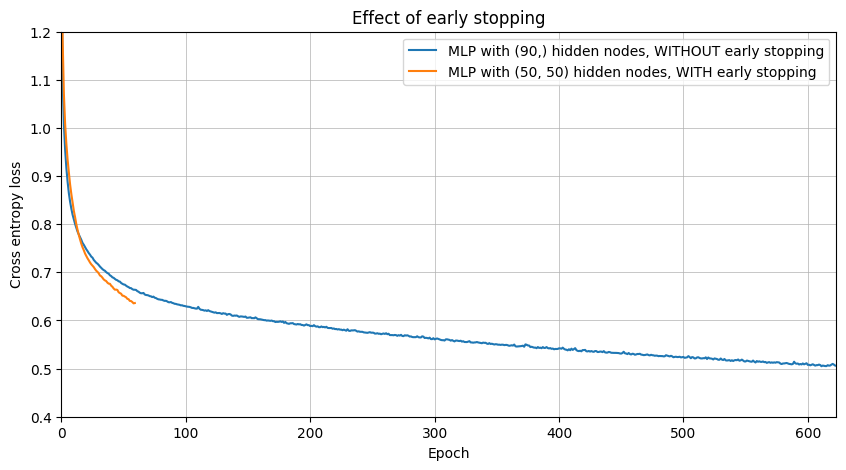

In [92]:
# Es una buena práctica mirar la curva de aprendizaje, para ver cuánto ha mejorado el modelo desde el punto inicial,
# y cómo ha evolucionado a lo largo de las épocas.
# El gráfico de la curva de aprendizaje también ilustra bien lo que hace el early_stopping.
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(mlp.loss_curve_,label=f'MLP with {mlp.hidden_layer_sizes} hidden nodes, WITHOUT early stopping')
plt.plot(mlp_early_st.loss_curve_,label=f'MLP with {mlp_early_st.hidden_layer_sizes} hidden nodes, WITH early stopping')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross entropy loss')
ax.grid(True,linewidth = 0.5)
ax.set_ylim(0.4,1.2)
ax.set_xlim(0,mlp.n_iter_)
ax.set_title('Effect of early stopping')
ax.legend()

In [93]:
# Usemos nuestra función de evaluación de nuevo para evaluar el rendimiento del MLP con parada temprana en el conjunto de datos de entrenamiento y prueba
eval_train_early_st = eval_performance(mlp_early_st.predict_proba(X_train.values),np.transpose([Y_train ==1,Y_train ==2,Y_train ==3, Y_train ==4]), X_train[['av_car','av_bus','av_rail','av_air']])
eval_test_early_st  = eval_performance(mlp_early_st.predict_proba(X_test.values), np.transpose([Y_test  ==1,Y_test  ==2,Y_test  ==3, Y_test  ==4]), X_test[['av_car','av_bus','av_rail','av_air']])

pd.options.display.float_format = '{:,.2f}'.format
results_early_st = pd.DataFrame({'data set':     ['Train','Test'],
                        'LL':           [eval_train_early_st[0], eval_test_early_st[0]],
                        'LL0':          [eval_train_early_st[1], eval_test_early_st[1]],
                        'cross_entropy':[eval_train_early_st[2], eval_test_early_st[2]],
                        'rho_sq':       [eval_train_early_st[3], eval_test_early_st[3]]})
print(results_early_st.T)

                      0         1
data set          Train      Test
LL            -2,878.94 -2,124.28
LL0           -4,902.96 -3,293.06
cross_entropy      0.69      0.76
rho_sq             0.41      0.35


### ``Ejercicio 4: ¿Podemos sobreajustar con early stopping?``
`A` ¿La parada anticipada redujo el sobreajuste? ¿Cómo puedes ver esto en los resultados impresos?<br>
`B` Intenta si la parada anticipada también ayuda a evitar el sobreajuste cuando se usan más nodos, por ejemplo, 100, o (50,50) nodos

$\color{green}{\text{Añada aquí sus respuestas}}$

In [94]:
# Add your code here

In [95]:
# RESPUESTAS
# A Si, funciona muy bien para evitar el sobreajuste. Esto se puede ver por la brecha comparativamente pequeña entre la entropía cruzada en los conjuntos de datos de entrenamiento y prueba.
# B Si, incluso con (50,50) nodos, la brecha en la entropía cruzada entre los conjuntos de datos de entrenamiento y prueba permanece pequeña. Esto es una buena señal de que el modelo generaliza bien.

### `4. Utilizando la validación cruzada k-fold para evaluar la generalización del rendimiento`

La validación cruzada k-fold se utiliza comúnmente para **evaluar más precisamente la generalización del rendimiento** de una red dada. Mejora un enfoque simple de dividir sistemáticamente el conjunto de datos en k partes. La validación cruzada k-fold es especialmente crucial cuando se ajustan hiperparámetros (como veremos más adelante).

In [96]:
# Crear objeto MLP (MLP 'base' sin parada anticipada)
layers = 10
mlp_cv = MLPClassifier(hidden_layer_sizes = layers, solver='adam', learning_rate_init = 0.001, alpha=0, batch_size=250, activation = 'relu', max_iter = 2000) 

# Crear función de evaluación
# Es necesario crear una función de evaluación cuando se trabaja con cross_validate de sk-learn
# Establecemos `greater_is_better` en `False` ya que estamos minimizando la pérdida de entropía cruzada

logloss = make_scorer(log_loss, greater_is_better = False, needs_proba = True)

# Aplicar cross_validate, utilizando por ejemplo 5 folder
# Dado que usamos validación cruzada, el entrenamiento lleva n_folds veces más tiempo que usar una división de entrenamiento-prueba
n_folds = 5
cv_results = cross_validate(mlp_cv,dff_scaled[features],Y, cv = n_folds, scoring=logloss,return_train_score=True)

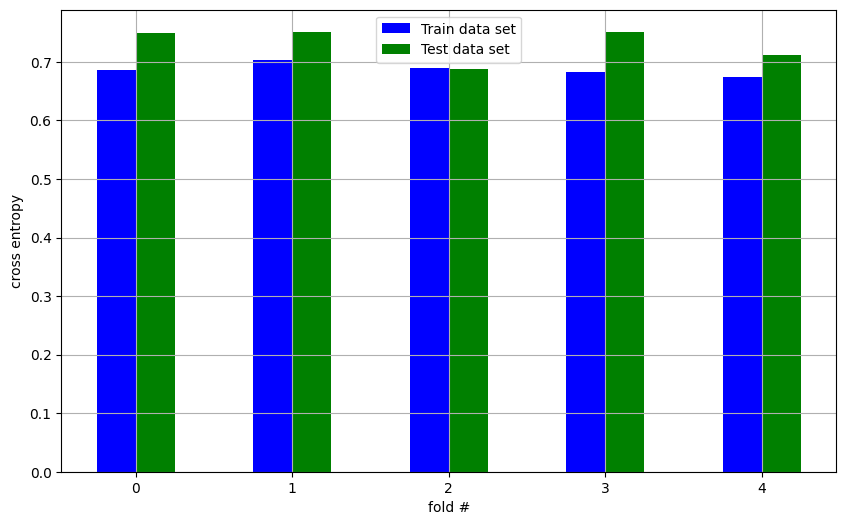

In [97]:
# Graficar el rendimiento de entrenamiento y prueba en un gráfico de barras, para cada fold
fig, ax = plt.subplots(figsize=(10, 6))
x_axis = np.arange(n_folds)
ax.bar(x_axis + -0.125, -cv_results['train_score'], color = 'b', width = 0.25,label = 'Train data set')
ax.bar(x_axis +  0.125, -cv_results['test_score'], color = 'g', width = 0.25,label = 'Test data set')
ax.set_xlabel('fold #')
ax.set_ylabel('cross entropy')
ax.grid()
ax.legend()

#### **Por tanto, este análisis de validación cruzada respalda la conclusión de que un MLP sencillo (es decir, sin parada temprana) overfit «moderadamente» a los datos**.

## `5. Ajuste de hiperparámetros`

Al entrenar MLPs (y la mayoría de otros modelos de ML), hay varios parámetros que podemos **'ajustar'** (optimizar) para mejorar el rendimiento del modelo. El proceso de hacer esto se llama **ajuste de hiperparámetros**. El ajuste de hiperparámetros se puede hacer manualmente, pero eso es engorroso. La función GridSearchCV en `sk-learn` automatiza el proceso de ajuste de hiperparámetros. Cuando se ajustan los hiperparámetros, es obligatorio utilizar un enfoque de validación cruzada k-fold. De lo contrario, existe el riesgo de sobreajustar en el conjunto de prueba *porque* los parámetros se pueden ajustar hasta que el estimador funcione de manera óptima en el conjunto de datos de prueba.

In [98]:
#######################################################################################################################################################

# No cambies estas líneas (aseguran que el código se ejecute lo suficientemente rápido en colab y local, reduciendo el nº de iteraciones para colab) ##

#######################################################################################################################################################

try:
    num_iters 
except NameError:
    num_iters = 2000
else:
    num_iters = 250

# Crear el objeto MLP (base MLP)
mlp_gs = MLPClassifier(activation = 'relu', solver='adam', batch_size=250, max_iter=num_iters)

# Define el espacio de búsqueda de hiperparámetros
# 'hidden_layer_sizes' define el número de nodos y capas
# 'alpha' gobierna la regularización L2
# 'learning_rate_init' gobierna la tasa de aprendizaje.

hyperparameter_space = {
    'hidden_layer_sizes': [(10),(10,10),(30,30)],
    'alpha': [0,0.01,1],
    'learning_rate_init': [0.01,0.001,0.0001]}

# Crear la funcion de evalaución
logloss = make_scorer(log_loss, greater_is_better = False, needs_proba = True)

# Crear el objeto grid_search, con el uso del clasificador MLP

folds = 5 # Número de divisiones de validación cruzada
mlp_gridsearch = GridSearchCV(mlp_gs, hyperparameter_space, n_jobs=-1, cv=folds,scoring = logloss)

In [99]:
# Ejecutar el entrenamiento/búsqueda en cuadrícula
# ¡Ten en cuenta que esto es costoso computacionalmente! 
# Puede tardar hasta 5 minutos, ya que hay que entrenar 3 x 3 x 3 = 27 modelos, cada uno con 5 pliegues (=135)
mlp_gridsearch.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(batch_size=250, max_iter=250),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.01, 1],
                         'hidden_layer_sizes': [10, (10, 10), (30, 30)],
                         'learning_rate_init': [0.01, 0.001, 0.0001]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

Guarde los resultados del ajuste de hiperparámetros para que sólo tengamos que hacerlo una vez.

In [100]:
filename = 'my_tuned_model.sav'
pickle.dump(mlp_gridsearch, open(filename,'wb'))

In [101]:
# Load your model (if you have a saved model)
# mlp_gridsearch = pickle.load(open(filename,'rb'))

Visualizar los resultados del ajuste de hiperparámetros

C:\Users\gnova\AppData\Local\Temp\ipykernel_36540\1644189425.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = df_gridsearch.gs_combinations,y=-df_gridsearch.mean_test_score,palette="Blues_d",)


Best hyperparameters found:	 {'alpha': 1, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.01}
Best model performance:		 0.7292151746385851


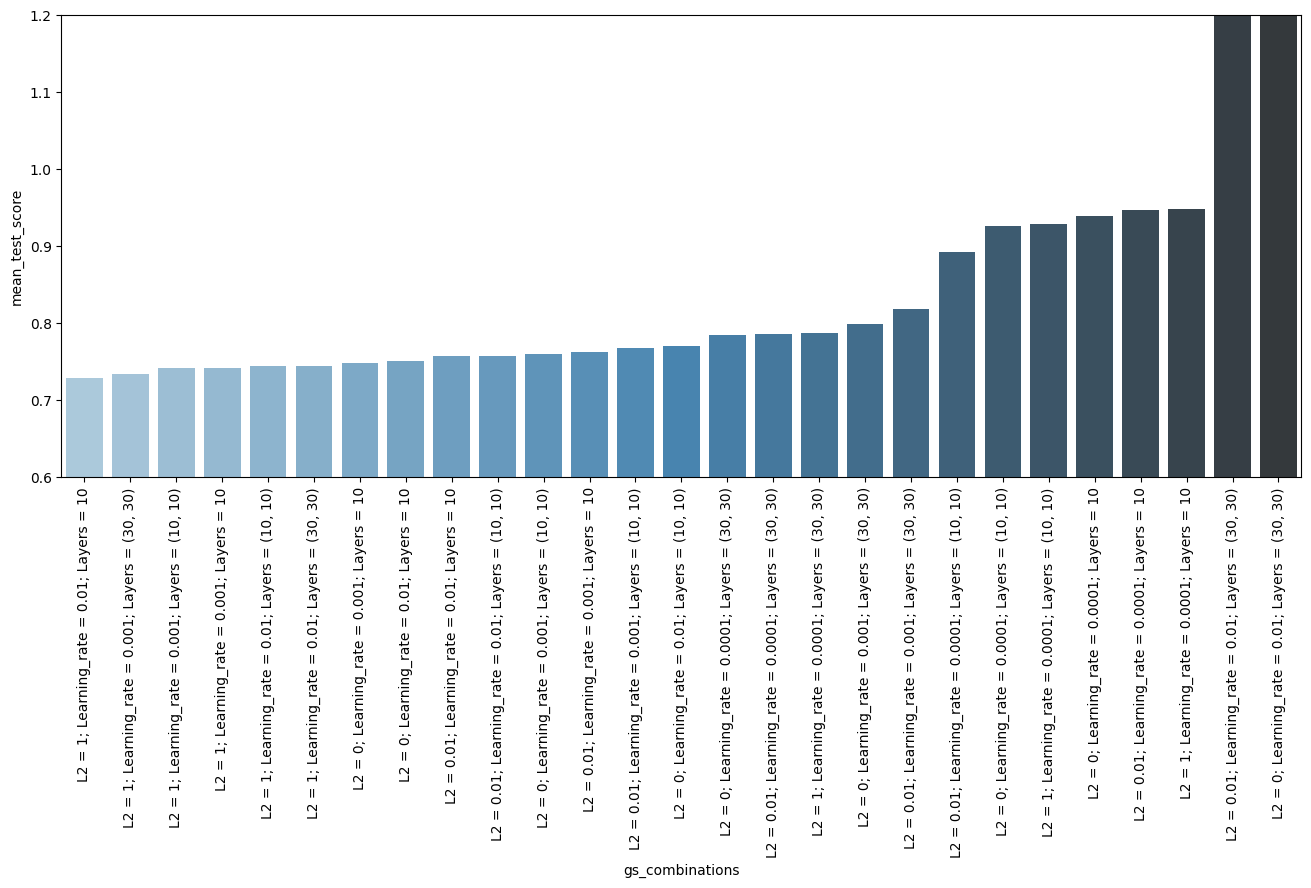

In [102]:
# Recoger los resultados en un nuevo marco de datos pandas
df_gridsearch = pd.DataFrame.from_dict(mlp_gridsearch.cv_results_)
    
#Añada una nueva columna con una etiqueta para las combinaciones de hiperparámetros %% AÚN ESTO NO ES LA MEJOR FORMA DE HACERLO EN PYTHON   
df_gridsearch['gs_combinations'] = 'L2 = '+ df_gridsearch['param_alpha'].astype('str') + '; Learning_rate = '+ df_gridsearch['param_learning_rate_init'].astype('str') + '; Layers = ' + df_gridsearch['param_hidden_layer_sizes'].astype('str')
df_gridsearch = df_gridsearch.sort_values('rank_test_score')

# Visualizar la desviación en el rendimiento a través de la configuración de hiperparámetros.
plt.figure(figsize = (16,6))
ax = sns.barplot(x = df_gridsearch.gs_combinations,y=-df_gridsearch.mean_test_score,palette="Blues_d",)
ax.set_ylim(0.6,1.2)
plt.xticks(rotation=90)

print('Best hyperparameters found:\t', mlp_gridsearch.best_params_)
print('Best model performance:\t\t', -mlp_gridsearch.best_score_)

### ``Ejercicio 5: Ajuste de hiperparámetros``
`A` Compara el rendimiento del modelo ajustado de hiperparámetros con el MLP 'base'. ¿Se ha mejorado la generalización del rendimiento ? ¿Cuánto?<br>
`B` ¿Qué hiperparámetro resulta ser particularmente impactante en el rendimiento del modelo?<br>
`C` ¿Puedes pensar en razones por las que esto podría ser así?

$\color{green}{\text{Añada aquí sus respuestas}}$

In [103]:
# Añade tu código aquí

In [104]:
# RESPUESTAS
# A El mejor rendimiento del modelo es: 0.734
# B La regularización L2 resulta ser muy importante. Casi todos los mejores modelos tienen alpha = 1
# C Los datos son comparativamente pequeños, en relación con el número de pesos de la red.
# Por lo tanto, no penalizamos demasiado los pesos en el modelo para evitar que capture anomalias en los datos.

**(Re)Entrenando el modelo con hiperparámetros optimizados**<br> 

Después de completar el ajuste de hiperparámetros, conoces los hiperparámetros óptimos. <br>
Por lo tanto, después del ajuste de hiperparámetros, siempre volvemos a entrenar el modelo utilizando los hiperparámetros optimizados.

In [105]:
# Crear un nuevo objeto mlp usando los hiperparámetros optimizados, sólo usando la división tren/prueba.

layers = mlp_gridsearch.best_params_['hidden_layer_sizes']
lr = mlp_gridsearch.best_params_['learning_rate_init']
alpha = mlp_gridsearch.best_params_['alpha']
mlp_gs = MLPClassifier(hidden_layer_sizes = layers, solver='adam', learning_rate_init = lr, alpha=alpha, batch_size=250, activation = 'tanh', max_iter = 2000) 

# Train the model
mlp_gs.fit(X_train,Y_train)

MLPClassifier(activation='tanh', alpha=1, batch_size=250, hidden_layer_sizes=10,
              learning_rate_init=0.01, max_iter=2000)

In [106]:
# También vamos a evaluar el rendimiento en el modelo hypertuned utilizando nuestra función de evaluación
# Nótese que aquí usamos los datos completos
eval_gridsearch = eval_performance(mlp_gs.predict_proba(dff_scaled[features]),np.transpose([Y ==1,Y ==2,Y ==3, Y==4]), dff_scaled[['av_car','av_bus','av_rail','av_air']])

pd.options.display.float_format = '{:,.2f}'.format
results_clf = pd.DataFrame({'data set': ['All data'],
                        'LL':           [eval_gridsearch[0]],
                        'LL0':          [eval_gridsearch[1]],
                        'cross_entropy':[eval_gridsearch[2]],
                        'rho_sq':       [eval_gridsearch[3]]})
print(results_clf.T)

                      0
data set       All data
LL            -5,109.61
LL0           -8,196.02
cross_entropy      0.73
rho_sq             0.38


### `6. Evaluación y comparación del rendimiento de los modelos entrenados

Para evaluar el rendimiento, hay una amplia gama de métricas disponibles, más allá del rendimiento de generalización.<br>
Aquí, observamos:<br>
i. Matriz de confusión<br>
ii. Precisión, Sensibilidad y Puntuación F1<br>
iii. Coeficiente de correlación de Matthew

**i) Matriz de confusión**<br>
Las matrices de confusión muestran recuentos de resultados predichos y reales. Los recuentos en la diagonal son resultados clasificados correctamente (las predicciones del modelo y la verdad del suelo son las mismas). Los recuentos en los elementos fuera de la diagonal son los resultados clasificados incorrectamente. Por lo tanto, el mejor clasificador tendrá una matriz de confusión con solo elementos diagonales y el resto de los elementos establecidos en cero.<br>
Comparamos el **RUM-MNL** contra el **MLP con ajuste de hiperparámetros**.

In [107]:
# Primero tenemos que simular las probabilidades de elección de cada alternativa para cada observación en el conjunto de datos de prueba utilizando biogeme
# Utilizándolas, podemos obtener las predicciones 0/1 (basadas en la probabilidad más alta)
biodata_sim = db.Database('biodata_sim_test', dff.iloc[test_indices,:])
prob_car  = models.logit(V, AV, 1)
prob_bus  = models.logit(V, AV, 2)
prob_air  = models.logit(V, AV, 3)
prob_rail = models.logit(V, AV, 4)

# Crear un diccionario con las probabilidad de elección de cada alternativa
simulate = {
    'Prob. car': prob_car,
    'Prob. bus': prob_bus,
    'Prob. air': prob_air,
    'Prob. rail': prob_rail}

# Simular las probabilidad de elección
biogeme_sim = bio.BIOGEME(biodata_sim, simulate)
simulated_values = biogeme_sim.simulate(results_rum_mnl.getBetaValues())

# Obtener 0/1 prediciones basado en la mayor probabilidad
Y_pred_mnl = np.argmax(simulated_values.values,axis=1)+1

The chosen alternative [`1.0`] is not available for the following observations (rownumber[choice]): 4[1.0]-14[1.0]-19[1.0]-21[1.0]-23[1.0]-27[1.0]-28[1.0]-32[1.0]-33[1.0]-37[1.0]-46[1.0]-48[1.0]-51[1....
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 8[2.0]-17[2.0]-34[2.0]-42[2.0]-51[2.0]-60[2.0]-69[2.0]-102[2.0]-109[2.0]-131[2.0]-139[2.0]-164[2.0]-...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 1[3.0]-4[3.0]-6[3.0]-7[3.0]-10[3.0]-15[3.0]-20[3.0]-25[3.0]-26[3.0]-27[3.0]-30[3.0]-39[3.0]-41[3.0]-...
The chosen alternative [`4.0`] is not available for the following observations (rownumber[choice]): 3[4.0]-14[4.0]-21[4.0]-23[4.0]-31[4.0]-37[4.0]-47[4.0]-70[4.0]-84[4.0]-90[4.0]-103[4.0]-114[4.0]-124...
The chosen alternative [`1.0`] is not available for the following observations (rownumber[choice]): 4[1.0]-14[1.0]-19[1.0]-21[1.0]-23[1.0]-27[1.0]-28[1.0]-32[1.0]-33[1.0]-37[1.0]-46[1.

Text(0.5, 1.0, 'MLP with 10 nodes / hyperparameters tuned \n Normalised')

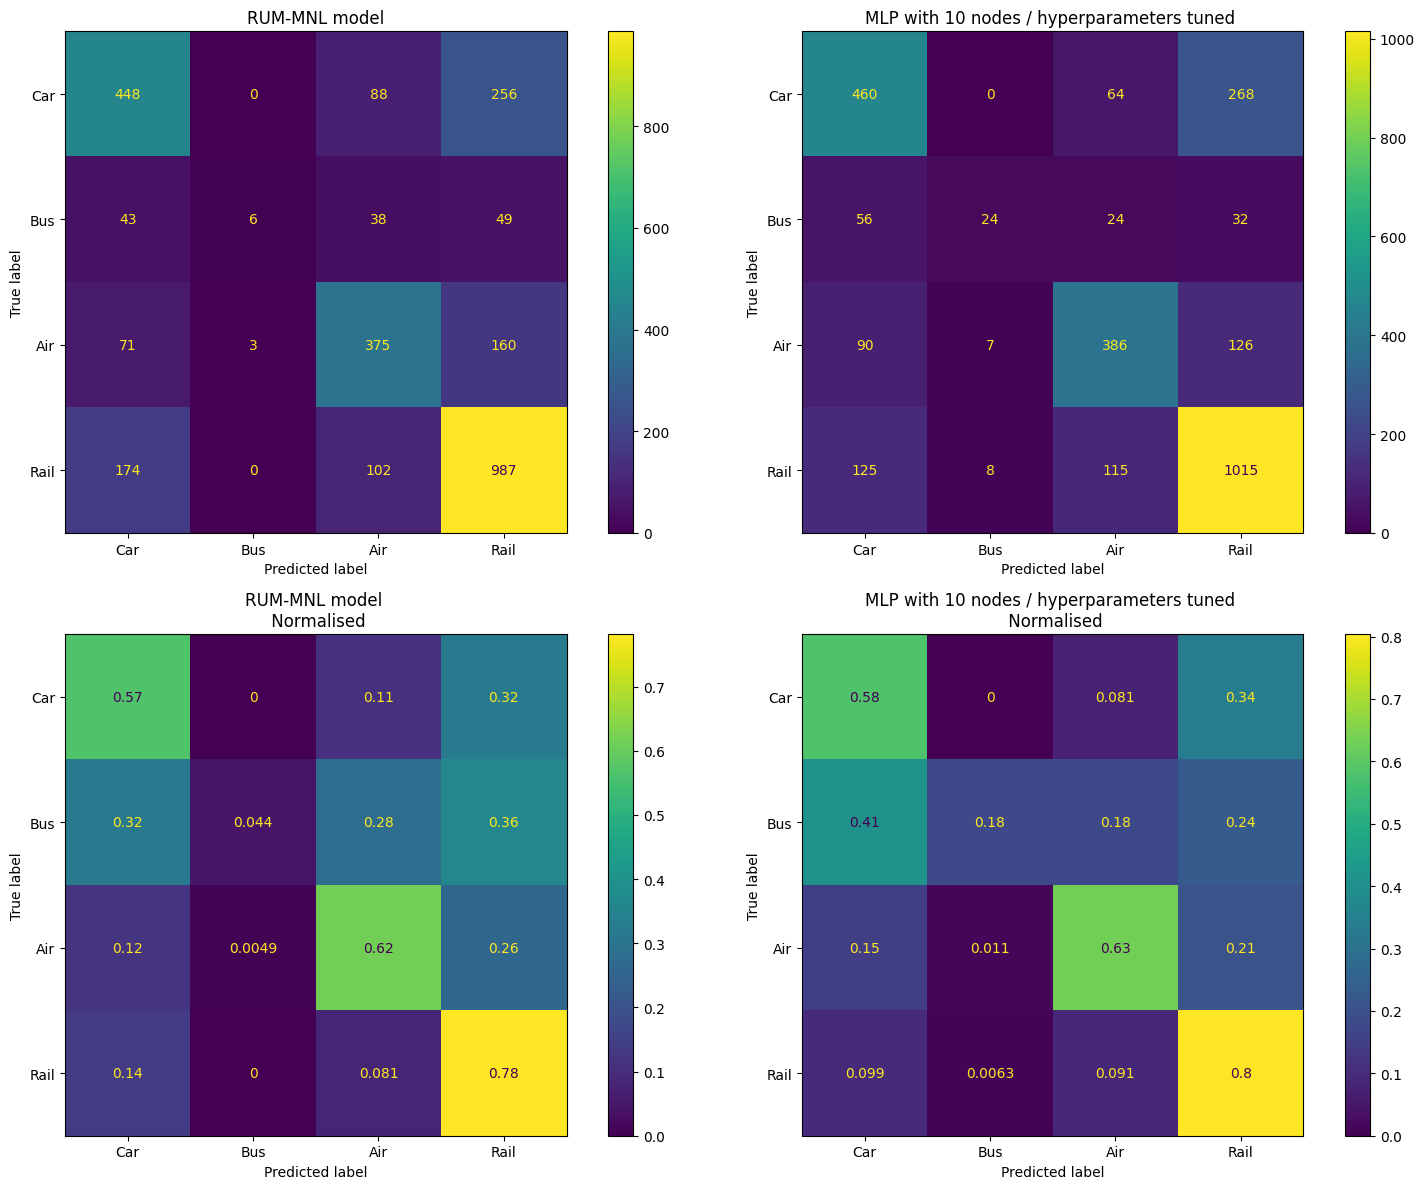

In [108]:
# Predecir las elecciones para el conjunto de datos de prueba, utilizando el MLP entrenado con parada temprana y MLP con hiperparámetros sintonizados.
Y_pred_gs = mlp_gs.predict(X_test)                     

# Mostrar las matrices de confusión, para comparar la red ajustada a hiperparámetros con la red de parada temprana.
fig, ax = plt.subplots(2,2,figsize = (16,12))
fig.set_tight_layout(True)
ylabels = ['Car', 'Bus', 'Air', 'Rail']
cm1 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_mnl, display_labels = ylabels, normalize= None, ax=ax[(0,0)])
cm2 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_mnl, display_labels = ylabels, normalize='true',ax=ax[(1,0)])
cm3 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_gs,  display_labels = ylabels, normalize= None, ax=ax[(0,1)])
cm4 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_gs,  display_labels = ylabels, normalize='true',ax=ax[(1,1)])

# Add titles
cm1.ax_.set_title(f'RUM-MNL model')
cm2.ax_.set_title(f'RUM-MNL model \n Normalised')
cm3.ax_.set_title(f'MLP with {mlp_gs.hidden_layer_sizes} nodes / hyperparameters tuned ')
cm4.ax_.set_title(f'MLP with {mlp_gs.hidden_layer_sizes} nodes / hyperparameters tuned \n Normalised')

### ``Ejercicio 6: Precisión del modelo``
La precisión se define como los verdaderos positivos sobre el número total de casos.<br>
`A` Calcula manualmente la precisión de predicción del modelo RUM-MNL y el modelo con ajuste de hiperparámetros<br>
`B` ¿Para qué clase (Carro, Autobús, Avión, Tren) mejora más el ajuste de hiperparámetros la precisión de la predicción?

$\color{green}{\text{Añada aquí sus respuestas}}$

In [109]:
# Add your code here

In [110]:
# RESPUESTAS
# A Precisión = elemento diagonal / total
#   MNL: (448+6+375+987)/3294 = 0.55
#   con ajuste de hiperparámetros: (483+31+414+991)/3294 = 0.58
# B Cambio por clase 
# Carro:   0.57 --> 0.62 = 0.05
# Autobús:   0.04 --> 0.20 = 0.16
# Avión:   0.62 --> 0.60 = -0.02
# Tren:  0.78 --> 0.79 = 0.01
# La precisión de la predicción mejora más para la clase Autobús

**ii) Precisión, recuperación y F1**<br>
Si se observan las matrices de confusión, las mejoras en la precisión de las predicciones debidas al ajuste de los hiperparámetros pueden no parecer muy impresionantes. Sin embargo, hay que tener en cuenta que las predicciones 0/1 son sensibles a los desequilibrios de clase, que están presentes en estos datos. Además, la precisión puede ser una métrica engañosa para conjuntos de datos desequilibrados. Un modelo ingenuo que simplemente predijera siempre «Ferrocarril» ya lo haría bastante bien.

Para evaluar el rendimiento del modelo con más profundidad, debemos analizar las predicciones a nivel de las clases.<br>

A continuación, calculamos Precisión, Sensibilidad y Puntuación F1.<br>
* **Precisión** Te dice qué fracción de las predicciones para una clase dada son realmente de esa clase.<br>
* **Sensibilidad** Indica qué fracción de todas las observaciones pertenecientes a una clase dada son correctamente predichas como tal por el modelo. La Sensibilidad también se conoce como Tasa de Verdaderos Positivos (TVP), Sensibilidad, Probabilidad de Detección.<br>
* **Puntuación F1** combina precisión y sensibilidad en una sola medida. Matemáticamente es la media armónica de precisión y sensibilidad. Se puede calcular de la siguiente manera: <br>

In [111]:
# Para calcular la precisión, el recal y la puntuación f1 utilizamos convenientemente la funcionalidad 'classification_report' de sk-learn
print('Classification report for RUM-MNL model\n',classification_report(Y_test,Y_pred_mnl, target_names= ylabels))
print('\nClassification report for plain vanilla MLP with hyperparameters tuned\n',classification_report(Y_test,Y_pred_gs, target_names= ylabels))

Classification report for RUM-MNL model
               precision    recall  f1-score   support

         Car       0.61      0.57      0.59       792
         Bus       0.67      0.04      0.08       136
         Air       0.62      0.62      0.62       609
        Rail       0.68      0.78      0.73      1263

    accuracy                           0.65      2800
   macro avg       0.64      0.50      0.50      2800
weighted avg       0.65      0.65      0.63      2800


Classification report for plain vanilla MLP with hyperparameters tuned
               precision    recall  f1-score   support

         Car       0.63      0.58      0.60       792
         Bus       0.62      0.18      0.27       136
         Air       0.66      0.63      0.64       609
        Rail       0.70      0.80      0.75      1263

    accuracy                           0.67      2800
   macro avg       0.65      0.55      0.57      2800
weighted avg       0.67      0.67      0.66      2800

